In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import random

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Report Data

In [5]:
def sample_skip_idx(file, pct, rand=False):
    '''
    Generate row index for sampling data
    
    Parameters
    ----------
    file : data file
    pct : percent of data to sample
    rand : randomly sample
    '''
    
    # total number of lines in file
    n_lines = sum(1 for line in open(file))
    
    # sample randomly
    if rand: 
        # sample size
        size = int(n_lines * pct/100)
        # row indicies to skip
        skip_idx = random.sample(range(1, n_lines), n_lines - size)
    # sample every nth row    
    else: 
        # number of lines to skip
        n = 1/pct*100
        # row indicies to skip
        skip_idx = [x for x in range(1, n_lines) if x % n != 0]
        
    # return row index to skip
    return(skip_idx)

In [6]:
# sample every 10th row
skiprows = sample_skip_idx('data/ufo_df.csv', 2)
ufo_df = pd.read_csv('data/ufo_df.csv', index_col=0, skiprows=skiprows)
ufo_df.head()

,datetime,geolocation,season,month,day,time_of_day,region,shape,duration,report_text
report_id,,,,,,,,,,
073/S73980,2010-01-04 19:10:00,"Cedar Rapids, IA",Winter,January,Monday,Evening,West North Central,Light,900.0,Two very bright white lights come close togeth...
074/S74075,2010-01-13 01:00:00,"Ackerman, MS",Winter,January,Wednesday,Night,East South Central,Light,7200.0,A bright light hovering in the southwestern sk...
074/S74148,2010-01-22 04:40:00,"Boise, ID",Winter,January,Friday,Night,Mountain,Changing,25.0,"33' Wide White Object seen over Boise, ID, em..."
074/S74266,2010-02-02 20:05:00,"Youngsville, LA",Winter,February,Tuesday,Evening,West South Central,Fireball,240.0,"On February 2, 2010, at approximately 8:05pm, ..."
074/S74375,2010-02-14 10:40:00,"Conover, NC",Winter,February,Sunday,Morning,South Atlantic,Circle,20.0,several round objects moving real fast across ...


In [7]:
len(ufo_df)

913

In [8]:
# report topic as target variable
y = pd.read_csv('data/ufo_tops.csv', index_col=0, header=None, names=['topic'])['topic']
y.head()

073/S73909          Fiery Lights
073/S73915    Object Description
078/S78231    Object Description
073/S73918     Light Description
073/S73916    Object Description
Name: topic, dtype: object

In [9]:
# sample target data
y = y[y.index.isin(ufo_df.index)]
y.head()

073/S73980         Fiery Lights
074/S74075    Craft Description
074/S74148    Light Description
074/S74266    Craft Description
074/S74375    Light Description
Name: topic, dtype: object

In [10]:
len(y)

913

In [11]:
# number of target classes
num_cls = len(y.unique())
num_cls

4

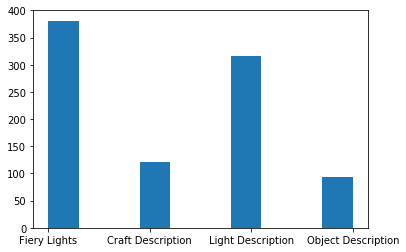

In [12]:
# topic histogram
plt.hist(y);

## Numerical Data

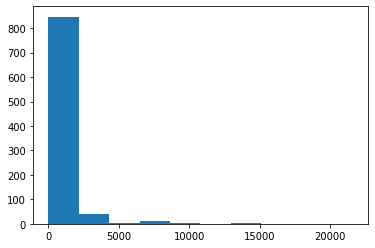

In [13]:
plt.hist(ufo_df['duration']);

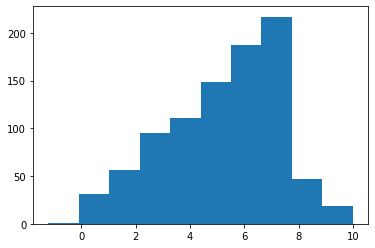

In [14]:
plt.hist(np.log(ufo_df['duration']));

### Log Transform

In [15]:
# transform numerical data to more normal distribution for modeling
X_num = np.log(ufo_df['duration'])

## Categorical Data

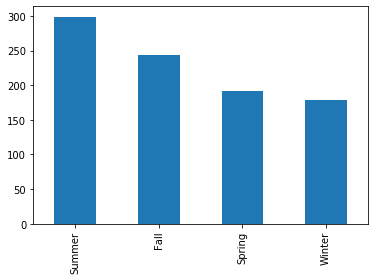

In [16]:
ufo_df['season'].value_counts().plot(kind='bar');

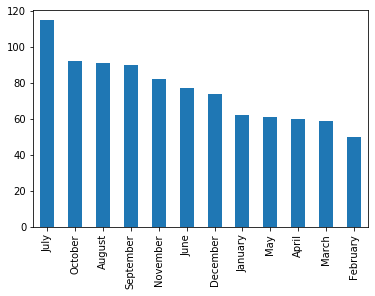

In [17]:
ufo_df['month'].value_counts().plot(kind='bar');

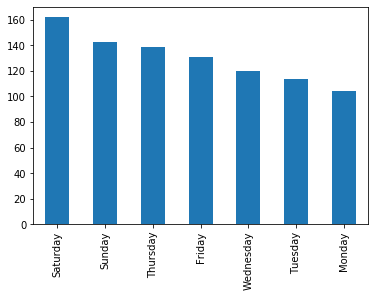

In [18]:
ufo_df['day'].value_counts().plot(kind='bar');

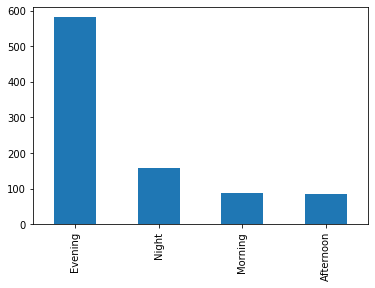

In [19]:
ufo_df['time_of_day'].value_counts().plot(kind='bar');

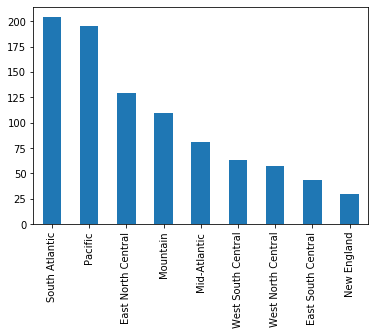

In [20]:
ufo_df['region'].value_counts().plot(kind='bar');

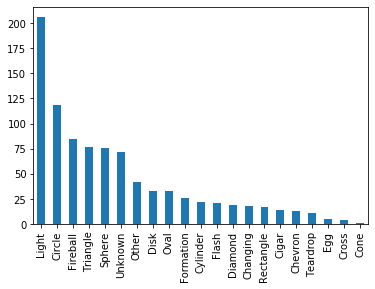

In [21]:
ufo_df['shape'].value_counts().plot(kind='bar');

### Encode

In [22]:
# encode categorical variables
X_cat = pd.get_dummies(ufo_df[['season', 'month', 'day', 'time_of_day', 'region', 'shape']])
X_cat.head()

,season_Fall,season_Spring,season_Summer,season_Winter,month_April,month_August,month_December,month_February,month_January,month_July,...,shape_Flash,shape_Formation,shape_Light,shape_Other,shape_Oval,shape_Rectangle,shape_Sphere,shape_Teardrop,shape_Triangle,shape_Unknown
report_id,,,,,,,,,,,,,,,,,,,,,
073/S73980,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
074/S74075,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
074/S74148,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
074/S74266,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
074/S74375,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Dataframe

In [23]:
# combine numerical and encoded categorical variables
X = pd.concat([X_num, X_cat], axis=1)
X.head()

,duration,season_Fall,season_Spring,season_Summer,season_Winter,month_April,month_August,month_December,month_February,month_January,...,shape_Flash,shape_Formation,shape_Light,shape_Other,shape_Oval,shape_Rectangle,shape_Sphere,shape_Teardrop,shape_Triangle,shape_Unknown
report_id,,,,,,,,,,,,,,,,,,,,,
073/S73980,6.802395,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
074/S74075,8.881836,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
074/S74148,3.218876,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
074/S74266,5.480639,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
074/S74375,2.995732,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Test/Train Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Logistic Regression Model

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [26]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
log_reg.score(X_test, y_test)

0.45842450765864334

In [28]:
log_reg_pred = log_reg.predict(X_test)
metrics.confusion_matrix(y_test, log_reg_pred)

array([[  0, 101,  34,   0],
       [  1, 274, 124,   0],
       [  0, 136, 145,   0],
       [  1,  73,  25,   0]])

In [29]:
print(metrics.classification_report(y_test, log_reg_pred))

                    precision    recall  f1-score   support

 Craft Description       0.00      0.00      0.00       135
      Fiery Lights       0.47      0.69      0.56       399
 Light Description       0.44      0.52      0.48       281
Object Description       0.00      0.00      0.00        99

       avg / total       0.34      0.46      0.39       914



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
logreg_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(3)),
    ('model', LogisticRegression())
])
logreg_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [31]:
logreg_pipe.score(X_train, y_train)

0.9181718664477285

In [32]:
logreg_pipe.score(X_test, y_test)

0.3687089715536105

In [33]:
logreg_pipe_pred = logreg_pipe.predict(X_test)
metrics.confusion_matrix(y_test, logreg_pipe_pred)

array([[ 20,  58,  48,   9],
       [ 47, 182, 137,  33],
       [ 23, 118, 123,  17],
       [ 12,  48,  27,  12]])

In [34]:
print(metrics.classification_report(y_test, logreg_pipe_pred))

                    precision    recall  f1-score   support

 Craft Description       0.20      0.15      0.17       135
      Fiery Lights       0.45      0.46      0.45       399
 Light Description       0.37      0.44      0.40       281
Object Description       0.17      0.12      0.14        99

       avg / total       0.36      0.37      0.36       914



## Regularize overfit model

In [59]:
# penalty_range = ['l1', 'l2']
C_range = np.linspace(0.0001, 0.01, 10)

In [60]:
C_range

array([0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078,
       0.0089, 0.01  ])

In [61]:
# hyperparams = {'model__penalty': penalty_range, 'model__C': C_range}
hyperparams = {'model__C': C_range}

In [62]:
log_tune = GridSearchCV(logreg_pipe, hyperparams, cv=3, scoring='accuracy')
log_tune.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__C': array([0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078,
       0.0089, 0.01  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [63]:
log_best = log_tune.best_estimator_
log_best.score(X_test, y_test)

0.4485776805251641

In [64]:
log_best

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('model', LogisticRegression(C=0.0023, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

# Gradient Boosted Trees

## XGBoost

In [42]:
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=num_cls, max_depth=10, gamma=0.5)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [43]:
xgb_clf.score(X_train, y_train)

/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9424657534246575

In [44]:
xgb_clf.score(X_test, y_test)

/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.3825136612021858

In [ ]:
xgb_pipe = Pipeline([
    ('poly', PolynomialFeatures(2)),
    ('model', XGBClassifier(objective='multi:softmax', num_class=num_cls, max_depth=15))
])
xgb_pipe.fit(X_train, y_train)

In [ ]:
xgb_pipe.score(X_train, y_train)

In [ ]:
xgb_pipe.score(X_test, y_test)

In [29]:
np.logspace(0, 5, 10)

array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05])

In [32]:
np.linspace(0, 5, 10)

array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ])

In [31]:
np.geomspace(0.001, 5, 10)

array([1.00000000e-03, 2.57630139e-03, 6.63732883e-03, 1.70997595e-02,
       4.40541340e-02, 1.13496727e-01, 2.92401774e-01, 7.53315095e-01,
       1.94076672e+00, 5.00000000e+00])

In [34]:
gamma_range = np.geomspace(0.001, 5, 10)

In [35]:
hyperparams = {'model_gamma': gamma_range}

In [45]:
xgb_tune = GridSearchCV(
    XGBClassifier(objective='multi:softmax', num_class=num_cls, max_depth=10), 
    hyperparams, 
    cv=3, 
    scoring='accuracy')
xgb_tune.fit(X_train, y_train)

/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_class=4,
       objective='multi:softmax', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model_gamma': array([1.00000e-03, 2.57630e-03, 6.63733e-03, 1.70998e-02, 4.40541e-02,
       1.13497e-01, 2.92402e-01, 7.53315e-01, 1.94077e+00, 5.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [46]:
xgb_best = xgb_tune.best_estimator_
xgb_best.score(X_test, y_test)

/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.37158469945355194

In [47]:
xgb_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       model_gamma=0.001, n_estimators=100, n_jobs=1, nthread=None,
       num_class=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

## GB Classifier

In [48]:
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [49]:
gb_clf.score(X_train, y_train)

0.7575342465753425

In [50]:
gb_clf.score(X_test, y_test)

0.37158469945355194